# Evaluation

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from SPARQLWrapper import SPARQLWrapper, JSON
%reload_ext jupyter-rdfify

## Read IMDb's recommendations of their top movies

In [2]:
imdb_recs_raw = pd.read_csv("data/imdb_recs_raw.csv")

imdb_recs_raw.head()

,title,recs
0,The Lives of Others,"Cinema Paradiso,The Hunt,Life Is Beautiful,The..."
1,The Shawshank Redemption,"The Dark Knight,Forrest Gump,The Godfather,Fig..."
2,Sunset Blvd.,"Double Indemnity,The Apartment,Witness for the..."
3,WALL·E,"Up,Toy Story,Finding Nemo,Ratatouille,Monsters..."
4,Raiders of the Lost Ark,"Indiana Jones and the Last Crusade,Indiana Jon..."


In [3]:
# Transform list column into several columns
# - One for each of the 12 recommendations
for i in range(0, 12):
    imdb_recs_raw[f"rec{i+1}"] = imdb_recs_raw["recs"].str.split(",").str[i]

imdb_recs_raw = imdb_recs_raw.drop(columns="recs")

imdb_recs_raw.head()

,title,rec1,rec2,rec3,rec4,rec5,rec6,rec7,rec8,rec9,rec10,rec11,rec12
0,The Lives of Others,Cinema Paradiso,The Hunt,Life Is Beautiful,The Intouchables,Downfall,City of God,Amélie,Capernaum,Rear Window,American Beauty,The Usual Suspects,Oldboy
1,The Shawshank Redemption,The Dark Knight,Forrest Gump,The Godfather,Fight Club,Inception,Pulp Fiction,The Green Mile,Schindler's List,Se7en,Interstellar,The Godfather Part II,The Lord of the Rings: The Return of the King
2,Sunset Blvd.,Double Indemnity,The Apartment,Witness for the Prosecution,Rear Window,Paths of Glory,Some Like It Hot,Vertigo,Citizen Kane,Casablanca,City Lights,North by Northwest,The Great Dictator
3,WALL·E,Up,Toy Story,Finding Nemo,Ratatouille,Monsters,Inc.,The Lion King,Toy Story 3,The Incredibles,Coco,Inside Out,How to Train Your Dragon
4,Raiders of the Lost Ark,Indiana Jones and the Last Crusade,Indiana Jones and the Temple of Doom,Indiana Jones and the Kingdom of the Crystal S...,Star Wars: Episode VI - Return of the Jedi,Star Wars: Episode V - The Empire Strikes Back,Star Wars: Episode IV - A New Hope,Back to the Future,Jurassic Park,Die Hard,Terminator 2: Judgment Day,Alien,Indiana Jones and the Dial of Destiny


## Check which movies are available in the triplydb dataset

In [4]:
# Specify the triplydb endpoint
sparql = SPARQLWrapper("https://api.triplydb.com/datasets/Triply/linkedmdb/services/linkedmdb/sparql")

def check_title(title):
    """
    Use this function to find out if a movie title exists on triplydb's limkedmdb.
    The function returns a boolean value, True if the title exists, False if not.
    """

    # Query for the movie title
    sparql.setQuery(f"""
        PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
        PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
        PREFIX lmdb: <https://triplydb.com/Triply/linkedmdb/vocab/>
        PREFIX actor: <https://triplydb.com/Triply/linkedmdb/id/actor/>
        PREFIX dc: <http://purl.org/dc/terms/>
        ASK WHERE {{
            ?movie rdf:type lmdb:Film .
            ?movie dc:title "{title}" .
        }}
    """)

    sparql.setReturnFormat(JSON)
    results = sparql.query().convert()
    return results["boolean"]

# Check for a title as an example
check_title("Titanic")

True

In [5]:
# Check which of the movies are available in triplydb's dataset

# Try to read csv first
try:
    mov_available = pd.read_csv("data/imdb_recs_availability.csv")

except FileNotFoundError:
    mov_available = pd.DataFrame()

    for col in imdb_recs_raw.columns:
        col_available = imdb_recs_raw[col].apply(check_title)
        col_available.to_frame(name=col)
        mov_available = pd.concat([mov_available, col_available], axis=1)

    mov_available.to_csv("data/imdb_recs_availability.csv", index=False)

mov_available.head()

,title,rec1,rec2,rec3,rec4,rec5,rec6,rec7,rec8,rec9,rec10,rec11,rec12
0,True,False,True,True,False,True,True,False,False,True,True,True,True
1,True,True,True,True,True,True,True,True,True,True,True,True,True
2,False,True,True,True,True,True,True,True,True,True,True,True,True
3,False,True,True,True,True,True,False,True,True,True,True,True,True
4,True,True,True,True,False,False,False,True,True,True,True,True,False


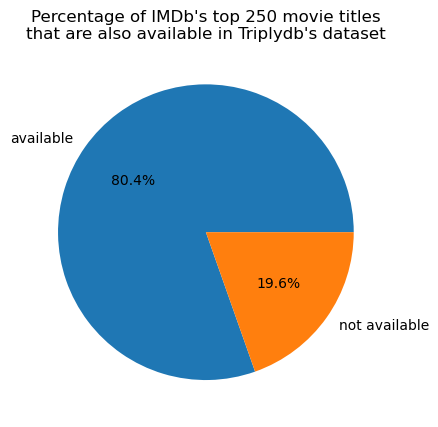

In [14]:
# Plot availability of source movies
src_available = mov_available["title"].sum()
src_unavailable = (~mov_available["title"]).sum()

fig, ax = plt.subplots()

ax.pie(
    [mov_available["title"].sum(), (~mov_available["title"]).sum()],
    labels=["available", "not available"],
    autopct='%1.1f%%'
)

ax.set_title("Percentage of IMDb's top 250 movie titles\nthat are also available in Triplydb's dataset")

plt.show()

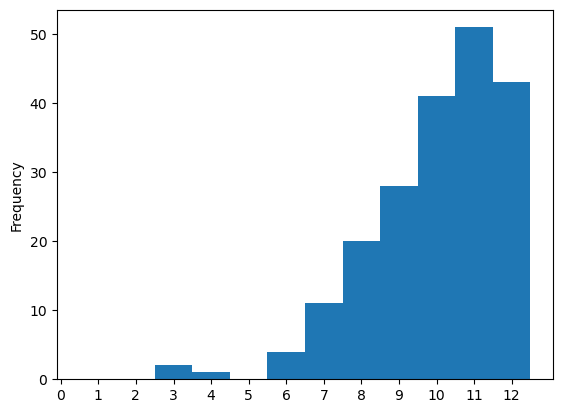

In [43]:
# Plot number of recommended movies that are available (only for available source movies)
fig, ax = plt.subplots()

mov_available[mov_available["title"]].iloc[:, 1:].sum(axis=1).plot(
    kind="hist",
    bins=[i+0.5 for i in range(13)],
    ax=ax
)

ax.set_xticks([i for i in range(13)])
ax.set_xticklabels([i for i in range(13)])

plt.show()

In [53]:
# List of movies that we can use to generate predictions for
imdb_recs_filtered = imdb_recs_raw[mov_available.sum(axis=1) == 13]["title"]
imdb_recs_filtered.to_csv("data/available_src_movies.csv", index=False)

## Evaluate Predictions

In [ ]:
# ...